In [63]:
from __future__ import print_function 

%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

import os, sys
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras import backend as K

import pandas as pd
import pickle
import gc, re, copy
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from IPython.display import display

# Project imports 
from data import mnist_m as mnistm
from data import mnist
from data.label_shift import label_shift_linear, plot_labeldist, plot_splitbars
from data.tasks import load_task
from experiments.training import *
from experiments.SL_bound import *
from experiments.DA_bound import *
from bounds.bounds import *
from util.kl import *
from util.misc import *
from results.plotting import *

# Hyper-parameters
TASK = 2

results_folder = "/cephyr/users/frejohk/Alvis/projects/mnist_transfer/results/task2/Binary"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
r_files = [f for f in os.listdir(results_folder) if 'results.pkl' in f]

D = pd.DataFrame({})
for r in r_files: 
    Dr = pd.read_pickle(os.path.join(results_folder, r))
    D = pd.concat([D, Dr], axis=0)

,Weightupdates,train_germain,target_germain,KL,e_s,e_t,d_tx,d_sx,error_std,target_error_std,e_s_std,e_t_std,d_tx_std,d_sx_std,alpha,sigma,epsilon,checkpoint,seed
0,0,0.076061,0.169728,0.000000,0.071037,0.161437,0.016581,0.010046,0.002460,0.004583,0.000873,0.001457,0.001736,0.001063,0.1,0.003,0.01,1_0,None
0,0,0.121185,0.177268,0.000000,0.053730,0.088077,0.178383,0.134909,0.014395,0.047555,0.002500,0.013480,0.020046,0.012927,0.1,0.030,0.01,1_0,None
0,45,0.063598,0.142942,5.582011,0.060436,0.137205,0.011473,0.006324,0.000838,0.002267,0.000540,0.001414,0.000886,0.000405,0.1,0.003,0.01,1_45,None
0,45,0.099994,0.172185,0.558201,0.045732,0.093363,0.157644,0.108524,0.018233,0.024616,0.001706,0.020624,0.006722,0.007713,0.1,0.030,0.01,1_45,None
0,90,0.151090,0.210344,1.659626,0.033963,0.054401,0.311887,0.234252,0.063296,0.036010,0.001682,0.007465,0.037462,0.011998,0.1,0.030,0.01,1_90,None


Sigma = 0.00300


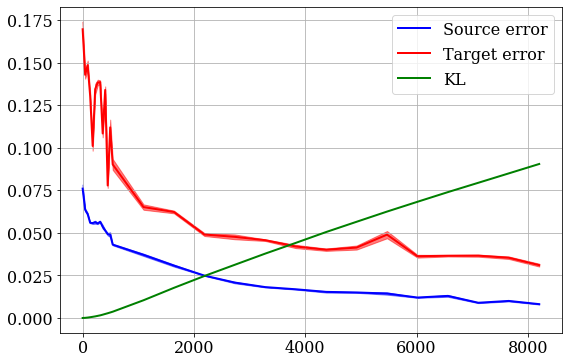

Sigma = 0.03000


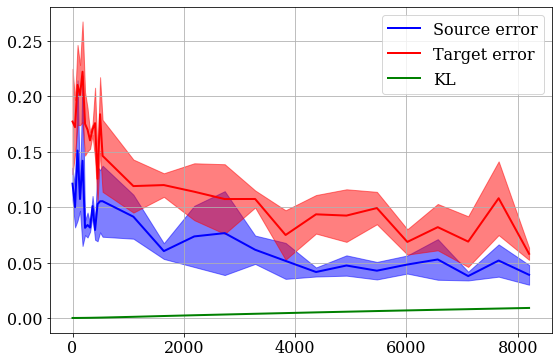

In [69]:
plt.rc('font', size=16, family='serif')
display(D.head(5))
D = D.sort_values(by='Weightupdates')

#plt.plot(D[D['sigma']==.03]['Weightupdates'], D[D['sigma']==.03]['train_germain'])
for s in np.sort(D['sigma'].unique()):
    print('Sigma = %.5f' % s)
    plt.figure(figsize=(9,6))
    plt.grid(zorder=-100)
    
    stratum = D['sigma']==s
    ws = D[stratum]['Weightupdates']
    e_so = D[stratum]['train_germain']
    e_ta = D[stratum]['target_germain']
    e_so_std = D[stratum]['error_std']
    e_ta_std = D[stratum]['target_error_std']
    KL = D[stratum]['KL']
    plt.plot(ws, e_so, label='Source error', lw=2, c='b')
    plt.fill_between(ws, e_so-e_so_std, e_so+e_so_std, alpha=0.5, zorder=0, color='b')
    
    plt.plot(ws, e_ta, label='Target error', lw=2, c='r')
    plt.fill_between(ws, e_ta-e_ta_std, e_ta+e_ta_std, alpha=0.5, zorder=0, color='r')
    
    plt.plot(ws, KL/70000, label='KL', lw=2, c='g')
    
    plt.legend()
    plt.show()